In [29]:
source("tstmle.R")
library(glue)
library(rje)
library(data.table)

origami v1.0.7: Generalized Framework for Cross-Validation


Attaching package: 'data.table'


The following object is masked from 'package:rje':

    last




<h1>Situation 1c: More Elaborate Dependence</h1>

$$
A(0: 6) \sim \text{Bern}(0.5) \\
Y(0: 6) \sim \text{Bern}(0.5) \\
W_1(0: 6) \sim \text{Bern}(0.5) \\
W_2(0: 6) \sim \text{Normal}(0, 1) \\

A(6 : n) \sim \text{Bern}\bigg(\text{expit}\big(0.7 * W_1(t-2) - 0.3*A(t-1) + 0.2 * sin(W_t(t-2) * A(t-3))\big)\bigg) \\
 
Y(6 : n) \sim \text{Bern}\bigg(\text{expit}\big(1.5 * A(t) - (W_1(t-1) * A(t-2))^2 + 0.9 * sin(W_2(t-4))*A(t-3)*cos(W_2(t-6)) - abs(W_2(t-5)>0)\big)\bigg) \\

W_1(6:n) \sim \text{Bern}(\text{expit}(0.5 * W_1(t-1) - 0.5 * Y(t-1) + 0.1*W_2(t-1)))\\

W_2(6: n) \sim \text{Normal}(0.6 * A(t-1)+Y(t-1)-W_1(t-1), 1) 
$$

In [121]:
N <- 100
MC <- 1
simulation_1c_true_ATE <- 0.279

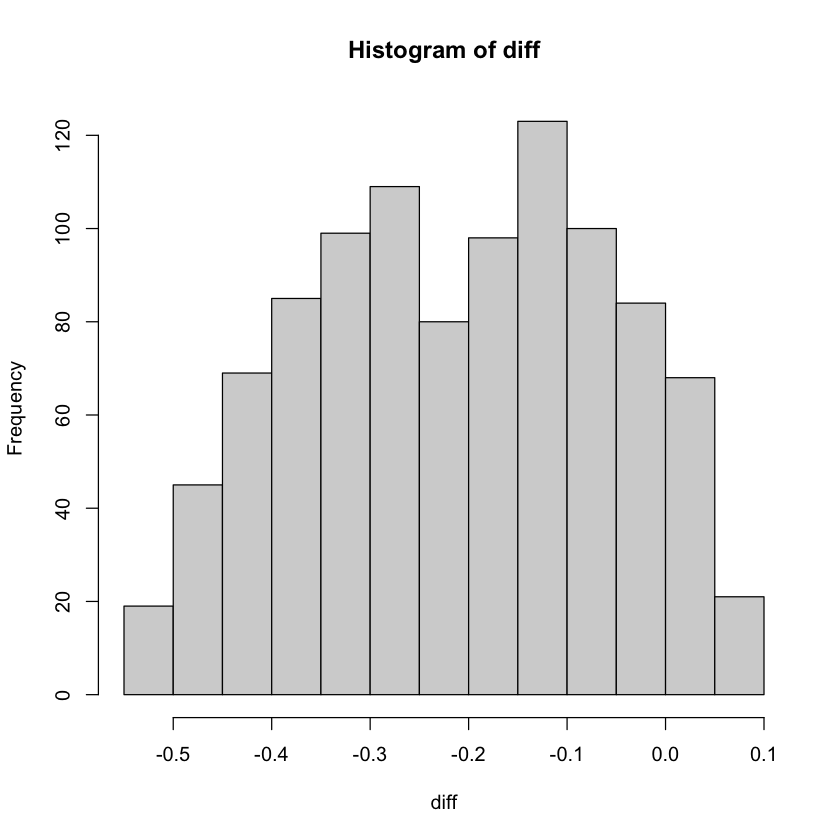

In [35]:
simulation_1c <- function(){
    # Using rbinom(_, 1, _) seems easiest way to get the behaviour of a bernoulli trial 
    W1 <- numeric(N)
    W2 <- numeric(N)

    W1[1:6] <- rbinom(6, 1, 0.5)
    W2[1:6] <- rnorm(6, 0, 1)

    A <- numeric(N)
    Y <- numeric(N)
    A[1:6] <- rbinom(6, 1, 0.5)
    Y[1:6] <- rbinom(6, 1, 0.5)

    diff <- numeric(N)
    # W[i, j] <- i'th row, j'th column
    for(i in 7:N){
        p <- expit(0.5*W1[(i-1)] - 0.5*Y[(i-1)] + 0.1*W2[i-1])
        W1[i] <- rbinom(1, 1, p)

        mu <- 0.6 * A[i-1] + Y[i-1] - W1[i-1]
        W2[i] <- rnorm(1, mu, 1)

        p <- expit(0.7 * W1[i-2] - 0.3*A[i-1] + 0.2 * sin(W1[i-2] * A[i-3]))
        A[i] <- rbinom(1, 1, p)

        p <- expit(1.5 * A[i] - (W1[i-1] * A[i-2])^2 + 0.9 * sin(W2[i-4])*A[i-3]*cos(W2[i-6]) - abs(W2[i-5]))
        Y[i] <- rbinom(1, 1, p)

        p1 <- expit(1.5 * 0 - (W1[i-1] * 0)^2 + 0.9 * sin(W2[i-4])*0*cos(W2[i-6]) - abs(W2[i-5]))
        p2 <- expit(1.5 * 1 - (W1[i-1] * 1)^2 + 0.9 * sin(W2[i-4])*1*cos(W2[i-6]) - abs(W2[i-5]))
        diff[i] <- (p1 - p2)
    }

    hist(diff)
    data <- data.frame(W1,W2,A,Y)
    return(data)
}

sim <- simulation_1c()

In [84]:
simulation_1a <- function(){
    # Using rbinom(_, 1, _) seems easiest way to get the behaviour of a bernoulli trial 
    W <- data.frame(
        "W1" = rbinom(N, 1, 0.5),
        "W2" = ceiling(runif(N, 0, 3)), # Equivalent to uniform 1 to 3
        "W3" = rbinom(N, 1, 0.5)
    )

    A <- numeric(N)
    Y <- numeric(N)
    A[1:4] <- rbinom(4, 1, 0.5)
    Y[1:4] <- rbinom(4, 1, 0.5)

    # W[i, j] <- i'th row, j'th column
    for(i in 5:N){
        p <- expit(0.25*W[(i-1), 1] - 0.2*W[(i-1), 2] + 0.3*Y[(i-1)] 
            - 0.2*A[(i-1)] + 0.2*W[(i-2), 3]
        )
        A[i] <- rbinom(1, 1, p)
        p <- expit(0.3 - 0.8*W[(i-1), 1] + 0.1*W[(i-1), 2] + 0.2*W[(i-1),3] 
            + A[i] - 0.5*W[(i-2), 1] + 0.2*W[(i-2), 3] - (0.6*A[i-1]) + (0.2 * A[i-2])
        )
        Y[i] <- rbinom(1, 1, p)
    }

    data <- cbind(W,A,Y)
    return(data)
}

sim <- simulation_1a()

True ATE: 0.136

In [37]:
source("tstmle.R")
node_list <- list(
    W = c("W1","W2","W3"),
    A = "A",
    Y = "Y"
)

folds <- folds_vfold(nrow(sim), 20)

ATE_SPEC <- tmle_ATE(treatment_level = 1, control_level=0)
tmle_task <- make_tmle_task(ATE_SPEC, sim, node_list, folds, 4)  
head(tmle_task$data) 

W.W1,W.W2,W.W3,W.W1_lag_1,W.W1_lag_2,W.W1_lag_3,W.W2_lag_1,W.W2_lag_2,W.W2_lag_3,W.W3_lag_1,W.W3_lag_2,W.W3_lag_3,A_lag_1,A_lag_2,A_lag_3,Y_lag_1,Y_lag_2,Y_lag_3,A,Y
<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
0,3,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
1,3,0,0,0,0,3,1,0,0,0,0,0,1,0,1,1,0,0,1
0,2,0,1,0,0,3,3,1,0,0,0,0,0,1,1,1,1,0,0
1,2,1,0,1,0,2,3,3,0,0,0,0,0,0,0,1,1,0,1
1,3,0,1,0,1,2,2,3,1,0,0,0,0,0,1,0,1,1,1


In [38]:
folds <- origami::make_folds(fold_fun = folds_rolling_window, n=N, window_size = N/5, validation_size=20, gap=10, batch=N/25)

initial_likelihood <- ATE_SPEC$make_initial_likelihood(
    tmle_task,
    get_learner_list() 
)

g <- initial_likelihood$get_likelihood(tmle_task, node = "A")
updater <- ATE_SPEC$make_updater(cvtmle=FALSE)
targeted_likelihood <- ATE_SPEC$make_targeted_likelihood(initial_likelihood, updater)

In [46]:
int_out_ak(sim, node_list, targeted_likelihood, g, 3)

0.3754129
0.2231737
0.4246349
0.3657186
0.2551870
0.4216551
0.3016742
0.4456823
0.1957693
0.3215129
0.3168132


In [137]:
source("multi_interventions.R")
source("tstmle.R")

node_list <- list(
    W = c("W1","W2","W3"),
    A = "A",
    Y = "Y"
)

sim <- simulation_1a()
run_multi_interventions_tmle(sim, node_list, 3)

Warning message in private$.train(processed_task, trained_sublearners):
"Lrnr_hal9001 failed with message: Error in tapply(weights, foldid, sum): arguments must have same length
. It will be removed from the stack"
Warning message in private$.train(processed_task, trained_sublearners):
"Lrnr_hal9001 failed with message: Error in tapply(weights, foldid, sum): arguments must have same length
. It will be removed from the stack"
Warning message in private$.train(processed_task, trained_sublearners):
"The following learners failed for one or more folds and will be dropped from all folds:  Lrnr_hal9001"
Warning message in private$.train(processed_task, trained_sublearners):
"The following learners failed for one or more folds and will be dropped from all folds:  Lrnr_hal9001"


[1] 0.03960452


Warning message in private$.train(processed_task, trained_sublearners):
"Lrnr_hal9001 failed with message: Error in tapply(weights, foldid, sum): arguments must have same length
. It will be removed from the stack"
Warning message in private$.train(processed_task, trained_sublearners):
"Lrnr_hal9001 failed with message: Error in tapply(weights, foldid, sum): arguments must have same length
. It will be removed from the stack"
Warning message in private$.train(processed_task, trained_sublearners):
"The following learners failed for one or more folds and will be dropped from all folds:  Lrnr_hal9001"
Warning message in private$.train(processed_task, trained_sublearners):
"The following learners failed for one or more folds and will be dropped from all folds:  Lrnr_hal9001"


[1] 0.0426042


Warning message in private$.train(processed_task, trained_sublearners):
"Lrnr_hal9001 failed with message: Error in tapply(weights, foldid, sum): arguments must have same length
. It will be removed from the stack"
Warning message in private$.train(processed_task, trained_sublearners):
"Lrnr_hal9001 failed with message: Error in tapply(weights, foldid, sum): arguments must have same length
. It will be removed from the stack"
Warning message in private$.train(processed_task, trained_sublearners):
"The following learners failed for one or more folds and will be dropped from all folds:  Lrnr_hal9001"
Warning message in private$.train(processed_task, trained_sublearners):
"The following learners failed for one or more folds and will be dropped from all folds:  Lrnr_hal9001"


[1] 0.04701795


Warning message in setDT(data):
"Some columns are a multi-column type (such as a matrix column): [6]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."


[1] 0.05327205
[1] "hello world"
[1] 0.05327205


A tmle3_Fit that took 1 step(s)
   type                param  init_est  tmle_est          se      lower
1:  ATE ATE[Y_{A=1}-Y_{A=0}] 0.1058811 0.1092664 0.006254101 0.09700861
       upper psi_transformed lower_transformed upper_transformed
1: 0.1215242       0.1092664        0.09700861         0.1215242

In [144]:
est <- 0.1092664
se <- 0.006254101
se <- 0.05327205
true_target <- 0.136
Z <- 1.96

print(est + (1.96 * se))
print(est - (1.96 * se))

[1] 0.2136796


[1] 0.004853182


In [150]:
sqrt(N) * se^2

[1] 0.06345763

In [ ]:
readRDS("./simulation_data/simulation1a_MC50_N100.rds")

In [ ]:
tmle_fits <- data.table()
for (i in 1:10){
    sim <- simulation_1a()
    tmle_fits <- rbind(tmle_fits, run_multi_interventions_tmle(sim, node_list, 3)$summary)    
}
tmle_fits

In [126]:
mean(tmle_fits$tmle_est)

[1] 0.143662

In [15]:
#tmle_fits <- read.csv("simulation_data/multi_intervention_50_N1000.csv")
colnames(tmle_fits) <- c("tmle_est", "se")
Z <- 1.96
N <- 500
tmle_fits$"lower" <- tmle_fits$"tmle_est" - (1.96 * tmle_fits$"se")
tmle_fits$"upper" <- tmle_fits$"tmle_est" + (1.96 * tmle_fits$"se")
head(tmle_fits)

ERROR: Error in 1.96 * tmle_fits$se: non-numeric argument to binary operator


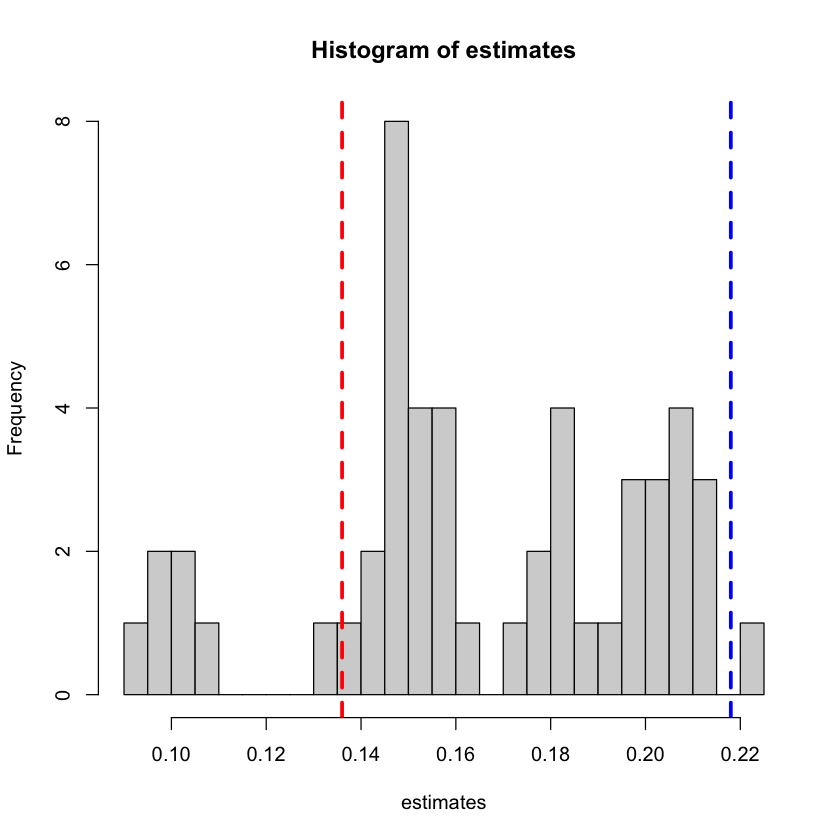

In [9]:
estimates <- tmle_fits$"tmle_est"
hist(estimates, breaks=20)
abline(v = 0.218, col='blue', lwd = 3, lty=2)
abline(v = 0.136, col='red', lwd = 3, lty=2)

In [12]:
average_bias <- function(tmle_fits, true_param){
    mean(tmle_fits$"tmle_est" - true_param)
}

average_variance <- function(tmle_fits, N){
    sqrt(N) * mean((tmle_fits$"se")^2)
}

coverage <- function(tmle_fits, true_param){
    n <- length(tmle_fits)
    agg <- numeric(n)
    for(i in 1:n){
        lower <- tmle_fits$"lower"[i]
        upper <- tmle_fits$"upper"[i]
        if(lower <= true_param && true_param <= upper){
            agg[i] <- 1
        }
    }
    return(mean(agg))
}
true_ATE <- 0.136
print(average_bias(tmle_fits, true_ATE))
print(average_variance(tmle_fits, N))
print(coverage(tmle_fits, true_ATE))

[1] 0.02955557
[1] 0.03182877
[1] 1


<h2>From Eddie Cluster </h2>

In [41]:
monte_carlo_draws <- 500
N <- 500
simulation_1c_true_ATE <- 0.279
folder <- "./simulation_data"

file <- glue("{folder}/simulation1c_MC{monte_carlo_draws}_N{N}.rds")

node_list <- list(
    W = c("W1", "W2"),
    A = "A",
    Y = "Y"
)
ate_spec <- tmle_ATE(treatment_level = 1, control_level=0)

tmle_fits <- data.table()

In [42]:
tmle_fits <- readRDS(file)

print(average_bias(tmle_fits, simulation_1c_true_ATE))

print(average_variance(tmle_fits, N))

print(coverage(tmle_fits, simulation_1c_true_ATE))

[1] -0.06656639
[1] 0.04111229
[1] 0.8


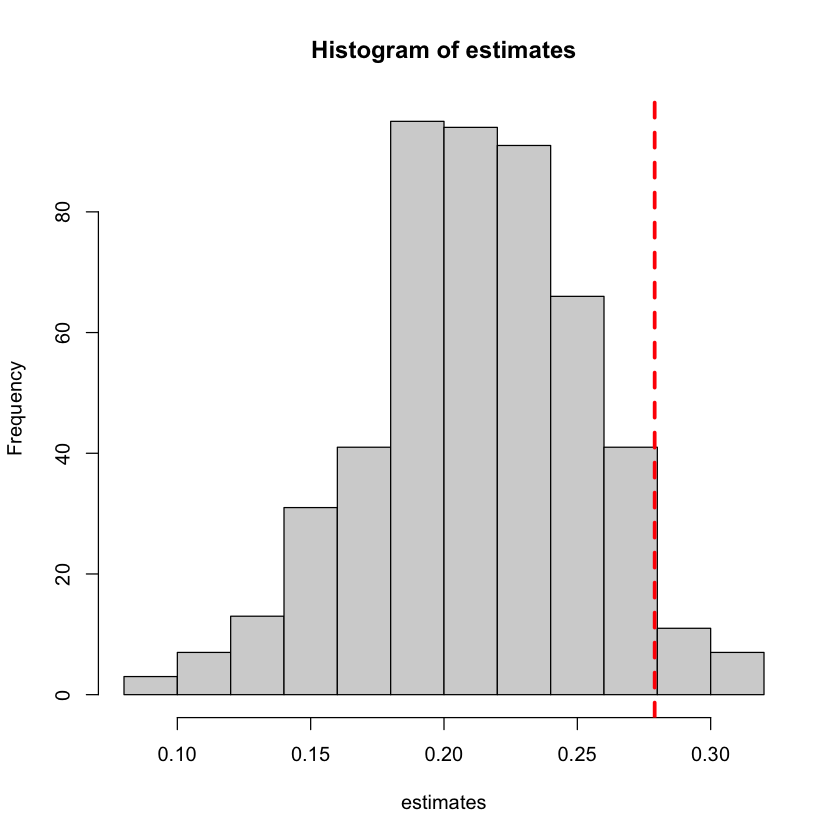

In [43]:
estimates <- tmle_fits$"tmle_est"
hist(estimates)
abline(v = simulation_1c_true_ATE, col='red', lwd = 3, lty=2)